In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from langdetect import detect, DetectorFactory
from wordcloud import WordCloud
from nltk.corpus import stopwords
from collections import Counter
from textblob import TextBlob

import string
import re

import spacy
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/codespace/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from nltk.corpus import stopwords
stopWords = stopwords.words('english')
print(stopWords[:10])

['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']


In [3]:
# Functions for data preparation and new features

# Function for calculating the average word length
def avg_word_length(text):
    words = text.split()
    if len(words) == 0:
        return 0
    return sum(len(word) for word in words) / len(words)

# Function for calculating the number of sentences
def sentence_count(text):
    sentences = re.split(r'[.!?]', text)  # Sentence splitting for '.', '!', '?'
    sentences = [s for s in sentences if s.strip()]  # Removes empty sentences
    return len(sentences)

# Function for counting special characters
def special_char_count(text):
    return len(re.findall(r'[^a-zA-Z0-9\s]', text))  # Finds all special characters

DetectorFactory.seed = 42  
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"

def prepare_features(df):
    # df = df.drop(columns='Unnamed: 0')
    # df[['title', 'text']] = df[['title', 'text']].fillna(' ')
    # Reverse labels into: fake=1, real=0
    # df['label'] = 1 - df['label']
    df['title_text'] = df['title'] + ' ' + df['text']

    df["text_word_count"] = df["text"].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
    df["title_word_count"] = df["title"].apply(lambda x: len(str(x).split()) if pd.notnull(x) else 0)
    
    df["text_unique_words"] = df["text"].apply(lambda x: len(set(x.lower().split())) if pd.notnull(x) else 0)
    
    df["text_char_count"] = df["text"].apply(lambda x: len(x) - x.count(' ') if pd.notnull(x) else 0)
    df["title_char_count"] = df["title"].apply(lambda x: len(x) - x.count(' ') if pd.notnull(x) else 0)

    # Applying the functions to the text column
    df['avg_word_length'] = df['text'].apply(lambda x: avg_word_length(str(x)))
    df['sentence_count'] = df['text'].apply(lambda x: sentence_count(str(x)))
    df['special_char_count'] = df['text'].apply(lambda x: special_char_count(str(x)))
    df['language'] = df['text'].astype(str).apply(detect_language)

    return df

In [4]:
def count_duplicates(df):

    dic = {
        'Metric': [ 
            'Duplicates in title',
            'Duplicates in text',
            'Duplicates in title or text column'
        ],
        'Count': [
            df.title.duplicated().sum(),
            df.text.duplicated().sum(),
            (df.title.duplicated() | df.text.duplicated()).sum()
        ],
        'Proportion': [
            df[df.title.duplicated()]['label'].mean() * 100,
            df[df.text.duplicated()]['label'].mean() * 100,
            ((df.title.duplicated() | df.text.duplicated()).sum()) / len(df) *100
        ],
        'Count Fake News': [
            len(df[df.title.duplicated() & df.label == 1]),
            len(df[df.text.duplicated() & df.label == 1]),
            ((df.title.duplicated() | df.text.duplicated()) & (df.label == 1)).sum()
        ],
        'Proportion Fake News': [
            len(df[df.title.duplicated() & df.label == 1]) / len(df) * 100,
            len(df[df.text.duplicated() & df.label == 1]) / len(df) * 100,
            ((df.title.duplicated() | df.text.duplicated()) & (df.label == 1)).sum() / len(df) * 100
        ]
    }
    
    df_result = pd.DataFrame(dic)
    return df_result

In [5]:
def plot_histograms_and_boxplots(df, num_cols):
    """
    Plots histograms and boxplots for given numerical columns.

    Parameters:
    - df (DataFrame): The input DataFrame.
    - num_cols (list): List of numerical column names.

    Returns:
    - None (displays the plots)
    """
    fig, ax = plt.subplots(nrows=len(num_cols), ncols=2, figsize=[15, len(num_cols) * 3])

    for i, col in enumerate(num_cols):
        # Histogram with KDE for label categories
        sns.histplot(df[col][df.label == 1], ax=ax[i][0], label="Fake", kde=True, alpha=0.5)
        sns.histplot(df[col][df.label == 0], ax=ax[i][0], label="Real", kde=True, alpha=0.5)
        ax[i][0].set_title(f'Histogram for {col} (Max: {df[col].max()})')
        ax[i][0].legend()

        # Boxplot
        sns.boxplot(x=df[col], ax=ax[i][1])
        ax[i][1].set_title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()

In [6]:
def clean_data(df):
    # drop unused column
    df = df.drop(columns='Unnamed: 0')
    # Reverse labels into: fake=1, real=0
    df['label'] = 1 - df['label']
    # Fill Nan-values with an empty string
    df[['title', 'text']] = df[['title', 'text']].fillna("")

    return df

In [7]:
# `text_cleaner` function
def text_cleaner(sentence):
    """Clean the text using NLP-Steps.
 
    Steps include: Lemmatization, removing stop words, removing punctuations 
 
    Args:
        sentence (str): The uncleaned text.
 
    Returns:
        str: The cleaned text.
        
    """

    # Create the Doc object named `text` from `sentence` using `nlp()`
    doc = nlp(sentence)
    # Lemmatization
    lemma_token = [token.lemma_ for token in doc if token.pos_ != 'PRON']
    # Remove stop words and converting tokens to lowercase
    no_stopWords_lemma_token = [token.lower() for token in lemma_token if token not in stopWords]
    # Remove punctuations
    clean_doc = [token for token in no_stopWords_lemma_token if token not in punctuations]
    # Use the `.join` method on `text` to convert string
    joined_clean_doc = " ".join(clean_doc)
    # Use `re.sub()` to substitute multiple spaces or dots`[\.\s]+` to single space `' '
    final_doc = re.sub('[\.\s]+', ' ', joined_clean_doc)
    return final_doc

# Data preparation

In [10]:
df = pd.read_csv('./data/WELFake_Dataset.csv')
df.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [11]:
# drop unused column
df = df.drop(columns='Unnamed: 0')
# Reverse labels into: fake=1, real=0
df['label'] = 1 - df['label']

Create new features for EDA:

- title_text: concatenate columns title and text
- text_word_count: # of words in text column
- title_word_count: # of words in title column
- text_unique_words: # of uniqe words in text column
- text_char_count: # of characters in text column
- title_char_count: # of characters in title column
- avg_word_length: average word length in text column
- sentence_count: # of sentences in text column
- special_char_count: # of special characters in text column
- language: estimated language for text column

In [12]:
df = prepare_features(df)

In [13]:
path = './data/df_prepared_features.csv'
with open(path, 'w', encoding='utf-8', newline='') as file:
    df.to_csv(file, index=False)

print(f"CSV file was successfully saved under: {path}")

CSV file was successfully saved under: ./data/df_prepared_features.csv


In [7]:
with open('./data/df_prepared_features.csv', 'r', encoding='utf-8') as file:
    df = pd.read_csv(file)

df.head()

,title,text,label,title_text,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count,language
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,871,18,405,4109,113,4.717566,59,182,en
1,NaN,Did they post their votes for Hillary already?,0,NaN,8,0,8,39,0,4.875000,1,1,en
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",0,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,34,18,31,179,120,5.264706,2,2,en
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,1,"Bobby Jindal, raised Hindu, uses story of Chri...",1321,16,676,6721,90,5.041635,62,209,en
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",0,SATAN 2: Russia unvelis an image of its terrif...,329,16,186,1588,80,4.823708,12,50,en


In [8]:
num_cols = df.select_dtypes(include=['number']).columns.drop('label')
cat_cols = df.select_dtypes(include=['object']).columns

# Exploratory Data Analysis

In [9]:
print('First rows of the dataset:\n')
df.head(10)

First rows of the dataset:



,title,text,label,title_text,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count,language
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,871,18,405,4109,113,4.717566,59,182,en
1,NaN,Did they post their votes for Hillary already?,0,NaN,8,0,8,39,0,4.875000,1,1,en
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",0,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,34,18,31,179,120,5.264706,2,2,en
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,1,"Bobby Jindal, raised Hindu, uses story of Chri...",1321,16,676,6721,90,5.041635,62,209,en
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",0,SATAN 2: Russia unvelis an image of its terrif...,329,16,186,1588,80,4.823708,12,50,en
5,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,0,About Time! Christian Group Sues Amazon and SP...,244,13,153,1276,66,5.229508,13,41,en
6,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,DR. BEN CARSON TELLS THE STORY OF WHAT HAPPENE...,0,DR BEN CARSON TARGETED BY THE IRS: “I never ha...,15,20,15,66,86,4.400000,2,2,en
7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,0,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,0,12,0,0,68,0.000000,0,0,unknown
8,Sports Bar Owner Bans NFL Games…Will Show Only...,"The owner of the Ringling Bar, located south o...",0,Sports Bar Owner Bans NFL Games…Will Show Only...,265,19,173,1170,98,4.415094,14,33,en
9,Latest Pipeline Leak Underscores Dangers Of Da...,"FILE – In this Sept. 15, 2005 file photo, the ...",0,Latest Pipeline Leak Underscores Dangers Of Da...,485,9,308,2535,58,5.202062,28,122,en


In [12]:
print('General informations\n')
print(df.info())

General informations

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72134 entries, 0 to 72133
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               71576 non-null  object 
 1   text                72095 non-null  object 
 2   label               72134 non-null  int64  
 3   title_text          71537 non-null  object 
 4   text_word_count     72134 non-null  int64  
 5   title_word_count    72134 non-null  int64  
 6   text_unique_words   72134 non-null  int64  
 7   text_char_count     72134 non-null  int64  
 8   title_char_count    72134 non-null  int64  
 9   avg_word_length     72134 non-null  float64
 10  sentence_count      72134 non-null  int64  
 11  special_char_count  72134 non-null  int64  
 12  language            72134 non-null  object 
dtypes: float64(1), int64(8), object(4)
memory usage: 7.2+ MB
None


In [13]:
print("Number of missing values per column:\n")
print(df.isnull().sum())

Number of missing values per column:

title                 558
text                   39
label                   0
title_text            597
text_word_count         0
title_word_count        0
text_unique_words       0
text_char_count         0
title_char_count        0
avg_word_length         0
sentence_count          0
special_char_count      0
language                0
dtype: int64


There are entries with zero word length in the data set due to blank entries and missing values.

In [14]:
print('Total number of entries with zero word length in text column:', len(df[df.text_word_count == 0]))

print('\nof which are included of np.nan:', df['text'].isna().sum())
print('of which are included of blank entries:', (df.text[(df['text'] == ' ') | (df['text'] == '  ')].count()))
print('of which are included of \\n entries:', len(df[(df['text'] != ' ') & (df['text'] != '  ') & (df['text'].notna()) & (df['text_word_count'] == 0)]))

Total number of entries with zero word length in text column: 783

of which are included of np.nan: 39
of which are included of blank entries: 743
of which are included of \n entries: 1


In [17]:
print('Total number of entries with zero word length in title column:', len(df[df.title_word_count == 0]))
print('\nof which are included of np.nan:', df['title'].isna().sum())

Total number of entries with zero word length in title column: 558

of which are included of np.nan: 558


# Check categorical features

In [16]:
print("Statistical overview of categorical features:\n")
display(df.describe(include='object'))

Statistical overview of categorical features:



,title,text,title_text,language
count,71576,72095,71537,72134
unique,62347,62718,63121,32
top,Factbox: Trump fills top jobs for his administ...,,Highlights: The Trump presidency on April 13 a...,en
freq,14,738,8,70704


The difference between count and unique indicates the presence of duplicates. A total of 10,740 rows are affected, containing duplicates in either the text or title columns. Removing these would reduce the dataset by 15%.

In [18]:
count_duplicates(df)

,Metric,Count,Proportion,Count Fake News,Proportion Fake News
0,Duplicates in title,9786,6.345800,621,0.860898
1,Duplicates in text,9415,4.333510,408,0.565614
2,Duplicates in title or text column,10740,14.888957,791,1.096570


Approximately 98% of the entries are in English. Given the small proportion of other languages, it is advisable to remove them from the training dataset. Entries labeled as "unknown" consist of blank entries and URLs.

In [19]:
count_ct = pd.crosstab(index=df['language'], columns='Count')
proportion_ct = pd.crosstab(index=df['language'], columns='Proportion', normalize=True)
result = pd.concat([count_ct, proportion_ct], axis=1)
display(pd.DataFrame(result))

col_0,Count,Proportion
language,,
af,2,0.000028
ar,19,0.000263
ca,1,0.000014
cy,2,0.000028
da,1,0.000014
de,110,0.001525
el,2,0.000028
en,70704,0.980176
es,147,0.002038


In [20]:
df[df["language"] == "unknown"]

,title,text,label,title_text,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count,language
7,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,,0,HOUSE INTEL CHAIR On Trump-Russia Fake Story: ...,0,12,0,0,68,0.0,0,0,unknown
106,MARKETWATCH LEFTIST: MSM’s “Blatant” Anti Trum...,,0,MARKETWATCH LEFTIST: MSM’s “Blatant” Anti Trum...,0,10,0,0,59,0.0,0,0,unknown
325,Ohio State University Student Says Terrorist A...,,0,Ohio State University Student Says Terrorist A...,0,13,0,0,87,0.0,0,0,unknown
364,JULIAN ASSANGE REVEALS John Podesta’s Hilariou...,,0,JULIAN ASSANGE REVEALS John Podesta’s Hilariou...,0,16,0,0,99,0.0,0,0,unknown
421,HEATED! TUCKER CARLSON Totally Shuts Down Radi...,https://www.youtube.com/watch?v=RRPSCqkAJgk,0,HEATED! TUCKER CARLSON Totally Shuts Down Radi...,1,17,1,43,94,43.0,4,8,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71771,WOW! JILL STEIN’S ‘FIRESIDE CHAT’ Exposes Her ...,,0,WOW! JILL STEIN’S ‘FIRESIDE CHAT’ Exposes Her ...,0,11,0,0,63,0.0,0,0,unknown
71914,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,0,WATCH TUCKER CARLSON Scorch Sanctuary City May...,0,13,0,0,74,0.0,0,0,unknown
72026,BOOM! Woman Tries To Steal TRUMP Signs BUT Thi...,,0,BOOM! Woman Tries To Steal TRUMP Signs BUT Thi...,0,15,0,0,64,0.0,0,0,unknown
72119,BILL O’REILLY Destroys Liberal Pundit On Trump...,,0,BILL O’REILLY Destroys Liberal Pundit On Trump...,0,9,0,0,55,0.0,0,0,unknown


# Check numerical fetaures

The difference between the mean and median across all numerical features suggests the presence of skewed distributions and potential outliers in the dataset. This indicates that some values deviate significantly from the majority, which could impact statistical analyses and model performance.

In [21]:
print("\nStatistical overview of numerical features:\n")
df.describe()


Statistical overview of numerical features:



,label,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count
count,72134.000000,72134.000000,72134.000000,72134.000000,72134.000000,72134.000000,72134.000000,72134.000000,72134.000000
mean,0.485596,540.550933,12.173316,283.921410,2719.158233,65.231555,5.062291,30.532426,97.637647
std,0.499796,625.399748,4.255615,238.942487,3102.965371,21.921910,1.804421,38.268728,496.170294
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,227.000000,9.000000,147.000000,1144.000000,53.000000,4.833861,12.000000,32.000000
50%,0.000000,398.000000,12.000000,234.000000,2017.000000,62.000000,5.038491,21.000000,59.000000
75%,1.000000,667.000000,14.000000,358.000000,3377.000000,75.000000,5.242921,37.000000,110.000000
max,1.000000,24234.000000,72.000000,7009.000000,122490.000000,385.000000,149.000000,1562.000000,121808.000000


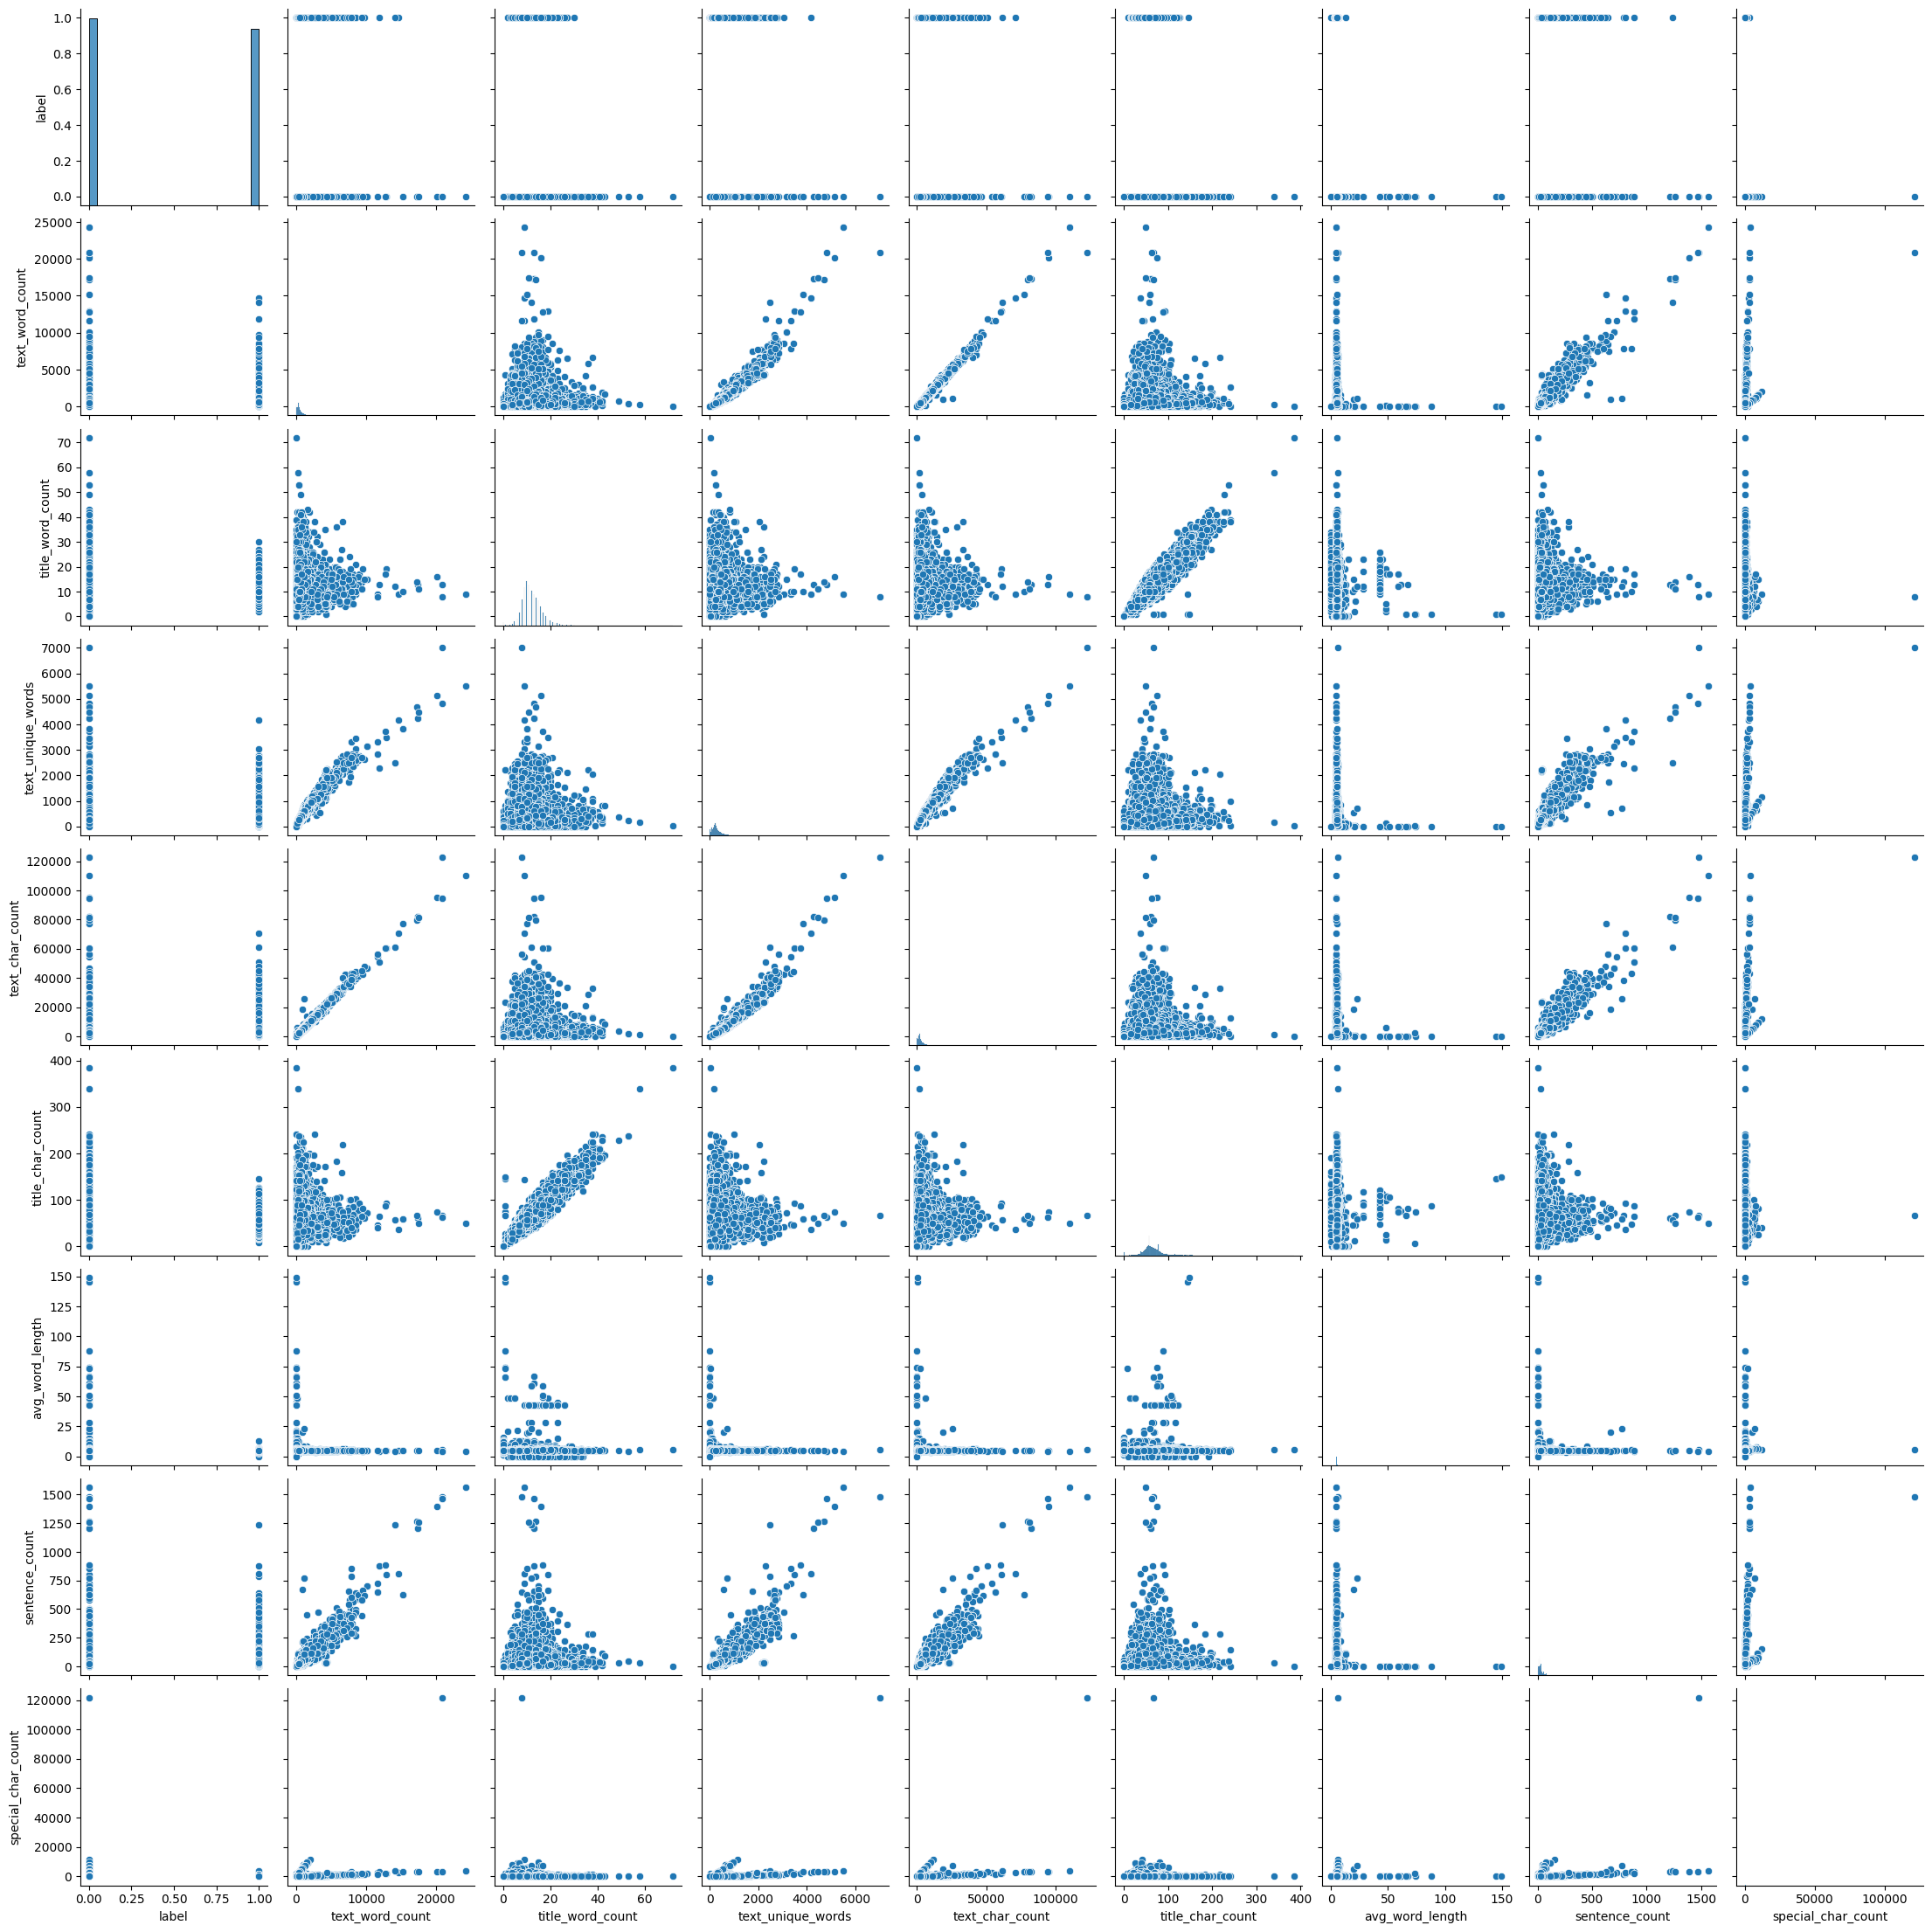

In [35]:
sns.pairplot(df)

label                 1.000000
sentence_count        0.083335
text_unique_words     0.080442
text_char_count       0.058763
text_word_count       0.057582
avg_word_length       0.018049
special_char_count    0.004179
title_word_count     -0.257237
title_char_count     -0.287657
Name: label, dtype: float64

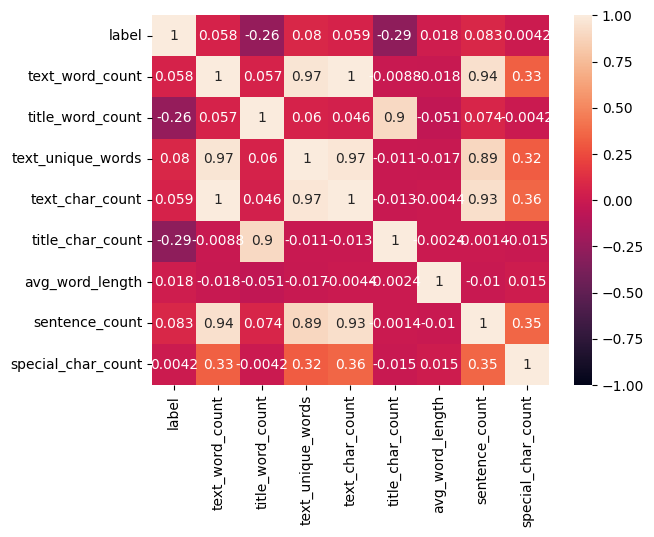

In [28]:
# visualize correlation matrix for numerical variables
df_corr = df.select_dtypes(include=['number']).corr()
sns.heatmap(df_corr, vmin=-1, vmax=1, annot=True);

df_corr['label'].sort_values(ascending = False)

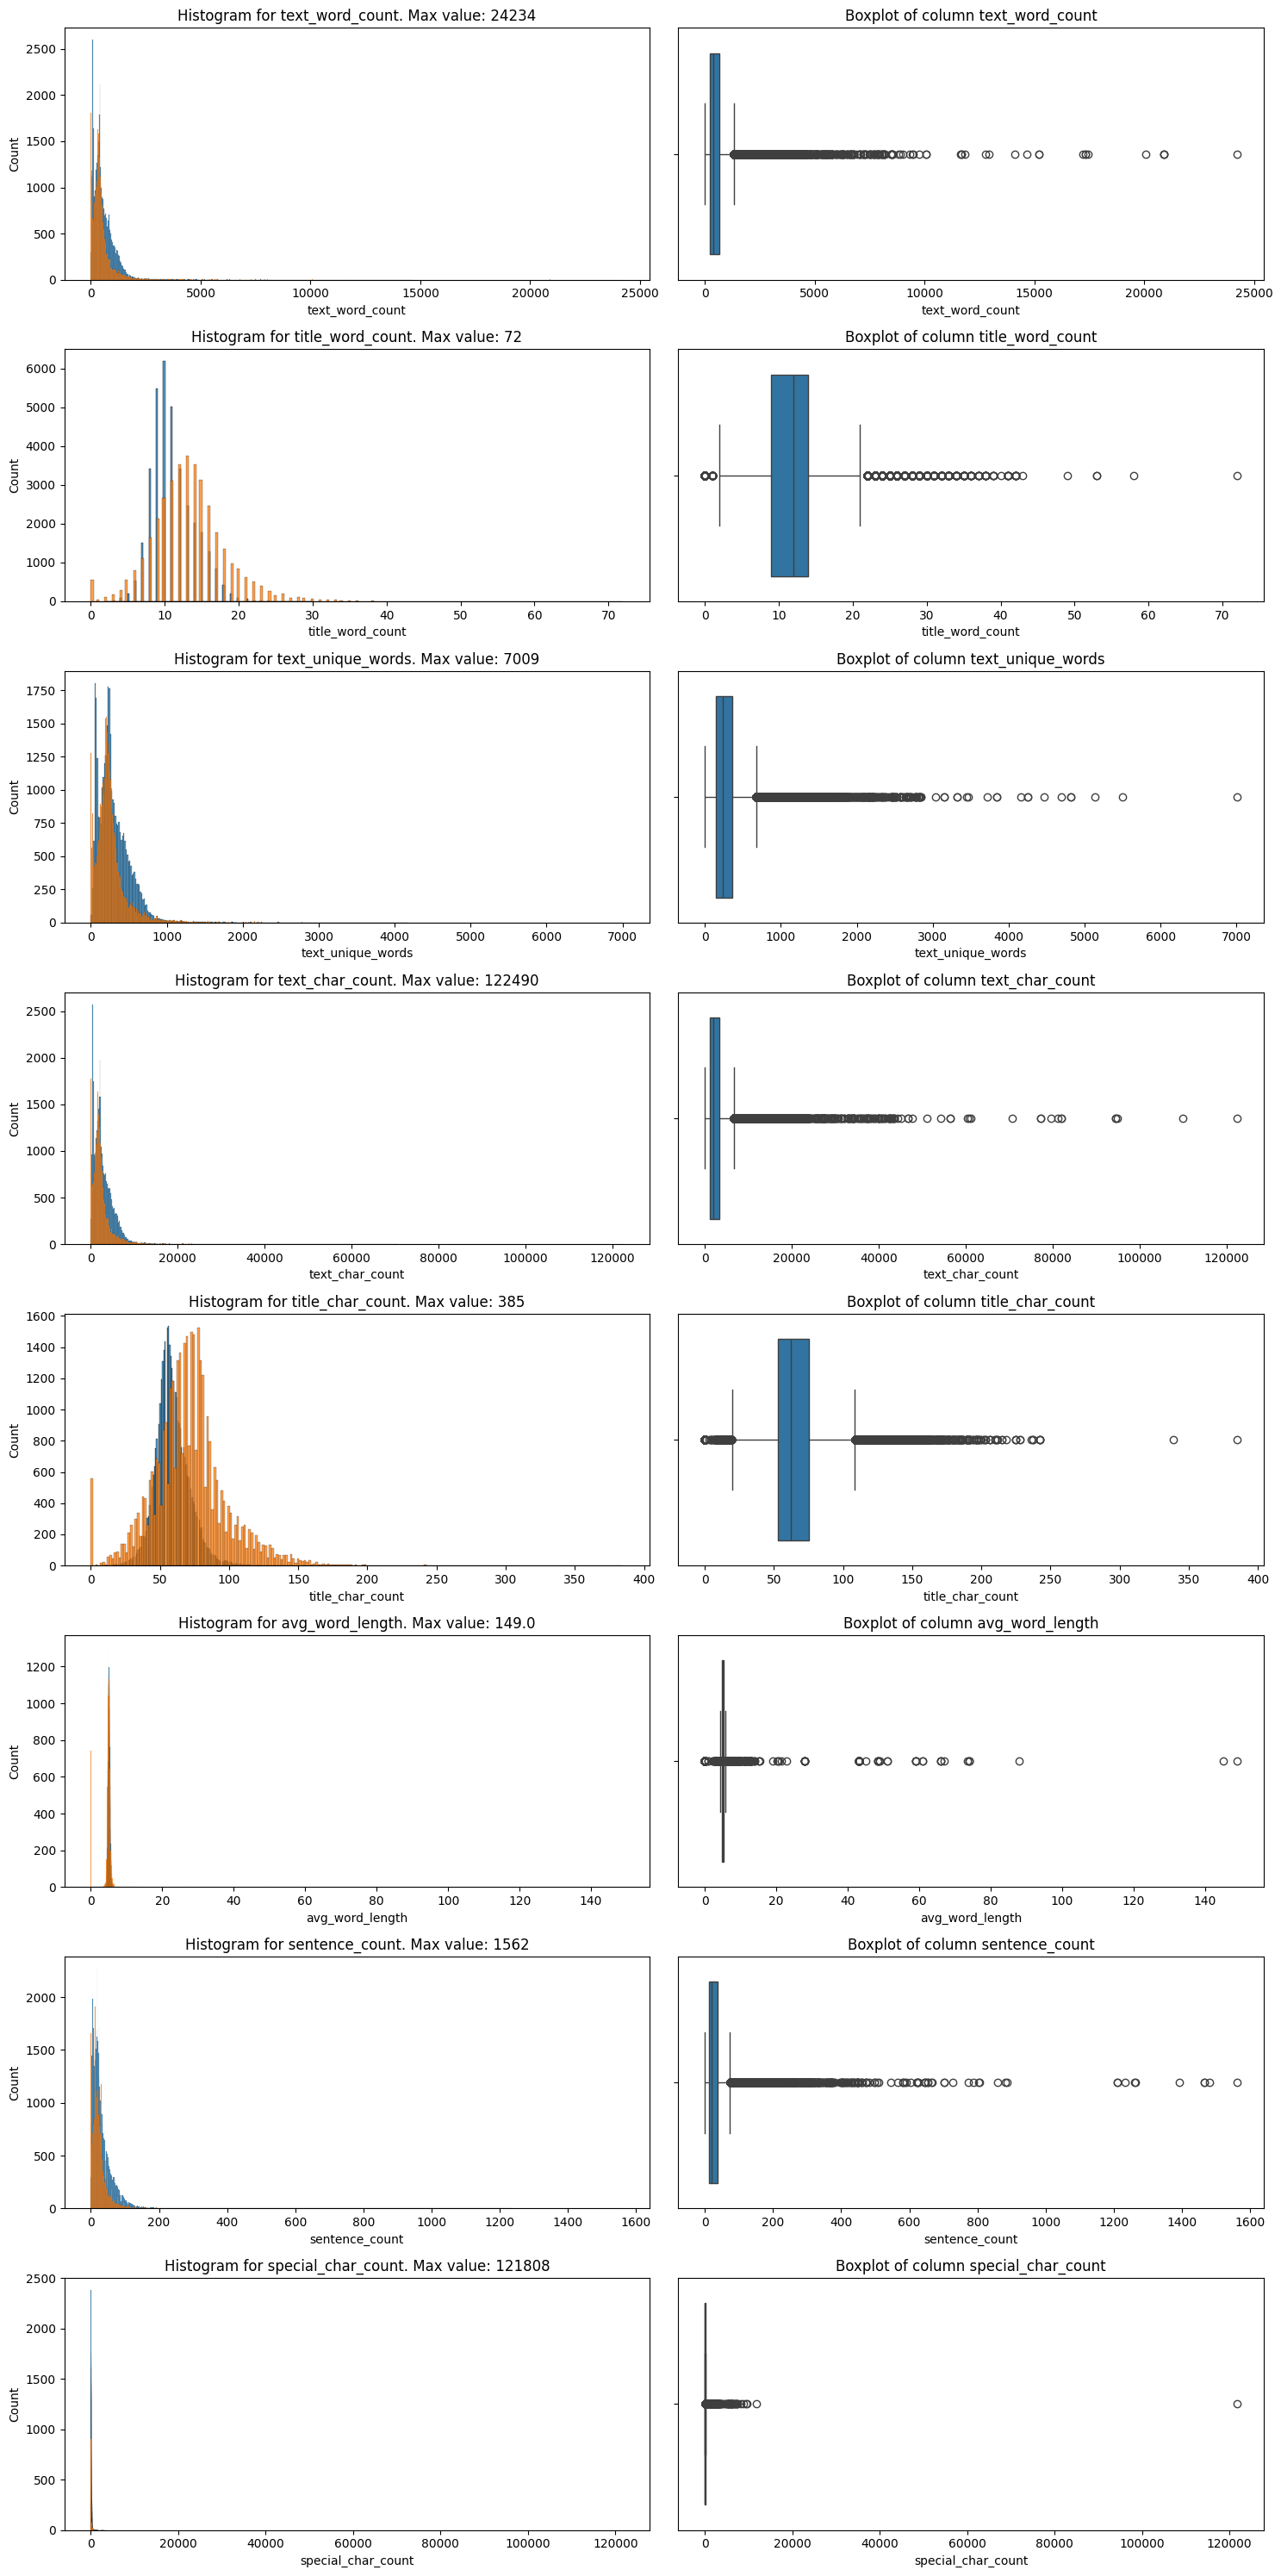

In [22]:
# Create subplots
fig, ax = plt.subplots(nrows=len(num_cols), ncols=2, figsize=[15, 30])

# Plotting histplots for each column
#for i, col in enumerate(num_cols):
    #sns.histplot(df[col][df.label == 1], ax=ax[i], label="Fake")
    #sns.histplot(df[col][df.label == 0], ax=ax[i], label="Real")
    #ax[i].set_title(f'Histogram for {col}. Max value: {df[col].max()}')
    #ax[i].legend()

# Plotting histograms and boxplots for each column
for i, col in enumerate(num_cols):
    # Histogram with KDE
    sns.histplot(df[col][df.label == 1], ax=ax[i][0], label="Fake")
    sns.histplot(df[col][df.label == 0], ax=ax[i][0], label="Real")
    ax[i][0].set_title(f'Histogram for {col}. Max value: {df[col].max()}')
    
    # Boxplot
    sns.boxplot(x=df[col], ax=ax[i][1])
    ax[i][1].set_title('Boxplot of column {}'.format(col))

# Adjust layout
plt.tight_layout()
plt.show()

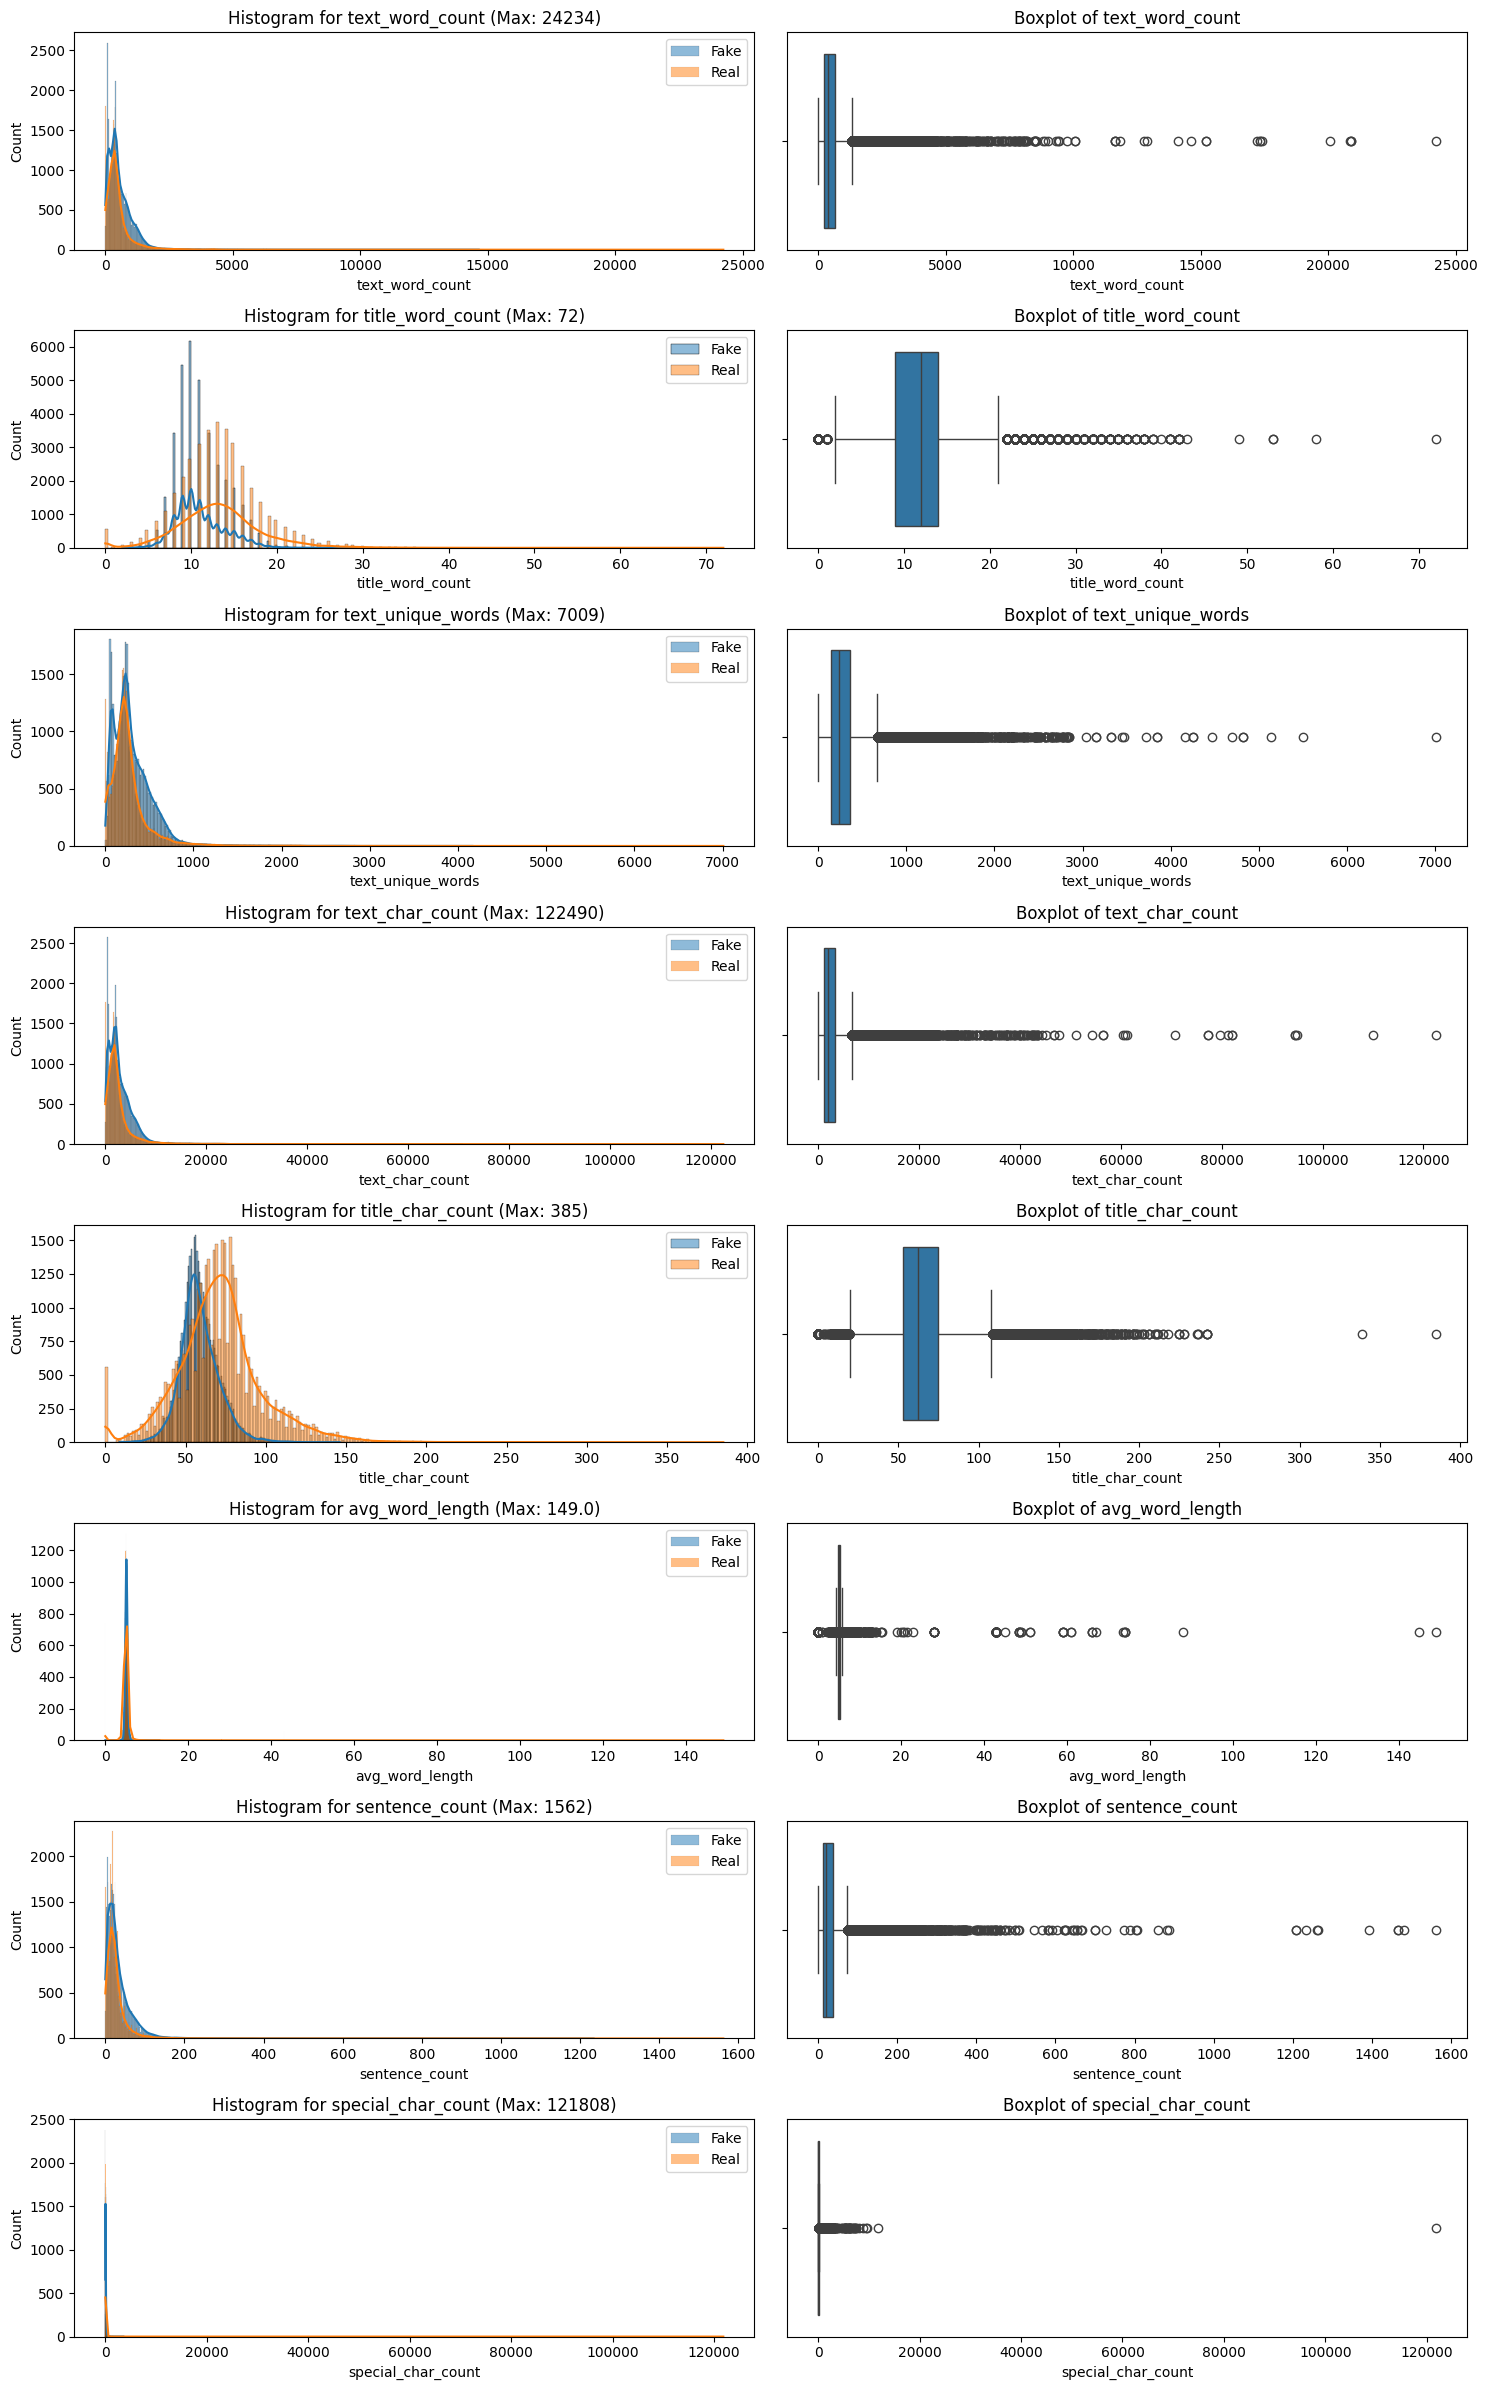

In [41]:
plot_histograms_and_boxplots(df, num_cols)

# Potential Outliers

There are only a few data points that significantly skew the distribution. Given the small number of data points used to determine the target category, these should be carefully examined as potential outliers, as they may disproportionately influence the analysis or model performance.

In [63]:
print(f'text_word_count == 0: {len(df[(df.text_word_count == 0)])}\nEmpty entries\n')
print(f'text_word_count > 0 & < 6: {len(df[(df.text_word_count > 0) & (df.text_word_count < 6)])}\nDue to the low word count, these entries could not be considered meaningful messages. Additionally, most single-word entries consist solely of a URL.\n')
print(f'text_word_count > 10000: {len(df[(df.text_word_count > 10000)])}\nApart from the fact that these entries are very long, they show no other abnormalities.\n')
print(f'title_word_count > 45: {len(df[df.title_word_count > 45])}\nApart from the fact that these entries are very long, they show no other abnormalities.\n')
print(f'text_unique_words > 3000: {len(df[df.text_unique_words > 3000])}\nApart from the fact that these entries show a huge amount of unique words, they show no other abnormalities.\n')
print(f'text_char_count > 50000: {len(df[df.text_char_count > 50000])}\nApart from the fact that these entries are very long, they show no other abnormalities.\n')
print(f'title_char_count > 300: {len(df[df.title_char_count > 300])}\nApart from the fact that these entries are very long, they show no other abnormalities.\n')
print(f'avg_word_length > 15: {len(df[df.avg_word_length > 15])}\nConsists almost exclusively of entries that only contain a URL.\n')
print(f'sentence_count > 550: {len(df[df.sentence_count > 550])}\nApart from the fact that these entries show a high number of sentences, they show no other abnormalities.\n')
print(f'special_char_count > 2000: {len(df[df.special_char_count > 2000])}\nConsists almost entirely of non-English messages. Also with an entry that is written in non-English characters, leading to a high frequency of special characters.\n')
print('language != "en": ',(len(df[df.language != 'en'])), '\nConsists mainly of empty entries.')

text_word_count == 0: 783
Empty entries

text_word_count > 0 & < 6: 247
Due to the low word count, these entries could not be considered meaningful messages. Additionally, most single-word entries consist solely of a URL.

text_word_count > 10000: 21
Apart from the fact that these entries are very long, they show no other abnormalities.

title_word_count > 45: 5
Apart from the fact that these entries are very long, they show no other abnormalities.

text_unique_words > 3000: 20
Apart from the fact that these entries show a huge amount of unique words, they show no other abnormalities.

text_char_count > 50000: 19
Apart from the fact that these entries are very long, they show no other abnormalities.

title_char_count > 300: 2
Apart from the fact that these entries are very long, they show no other abnormalities.

avg_word_length > 15: 99
Consists almost exclusively of entries that only contain a URL.

sentence_count > 550: 37
Apart from the fact that these entries show a high number of

In [66]:
df[df.special_char_count > 2000]

,title,text,label,title_text,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count,language
302,مذكرة مفاهيمية عن رئاسة الروسية,اجتماع لمجلس الأمن من 28 أكتوبر 2016\nمذكرة مف...,0,مذكرة مفاهيمية عن رئاسة الروسية اجتماع لمجلس ا...,1131,5,629,6282,27,5.537577,44,6225,ar
327,Re: The Hard Working American vs. The Governme...,The Hard Working American vs. The Government P...,0,Re: The Hard Working American vs. The Governme...,24234,9,5502,109973,49,4.513122,1562,3898,en
1966,Предикторские свойства толпы?,Паранормальное \nПрофессор американского униве...,0,Предикторские свойства толпы? Паранормальное \...,737,3,533,4581,27,6.198100,61,4529,ru
2301,Владивосток станет одним из главных портов в А...,В августе 2016 г. в г. Чанчунь (КНР) состоялся...,0,Владивосток станет одним из главных портов в А...,931,12,617,5777,65,6.205156,67,5535,ru
2636,В машине предполагаемых убийц Немцова обнаруже...,0 комментариев 4 поделились Фото: Fotodom.ru/К...,0,В машине предполагаемых убийц Немцова обнаруже...,340,7,261,2222,55,6.500000,30,2174,ru
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71180,"""Гражданам мира"" нужно не Отечество, а собстве...",0 комментариев 0 поделились Герман Греф. Фото:...,0,"""Гражданам мира"" нужно не Отечество, а собстве...",373,8,289,2304,56,6.144772,24,2263,ru
71296,Дай миллион! Я телевизор посмотрел…,Дай миллион! Я телевизор посмотрел… 18 ноября ...,0,Дай миллион! Я телевизор посмотрел… Дай миллио...,362,5,286,2195,31,6.052486,23,2184,ru
71687,Re: 55 Reasons Why California Is The Worst Sta...,55 Reasons Why California Is The Worst State I...,0,Re: 55 Reasons Why California Is The Worst Sta...,17427,11,4465,81270,49,4.640615,1262,2955,en
71853,Кто любит Стивена Сигала?,"Политика \nПомните первые видеосалоны 1990-х, ...",0,Кто любит Стивена Сигала? Политика \nПомните п...,409,4,304,2322,22,5.667482,22,2312,ru


Remove portential outliers and check distributions again.

In [64]:
df_rm = df.drop(df[
    (df.text_word_count == 0) | 
    ((df.text_word_count > 0) & (df.text_word_count < 6)) | 
    (df.text_word_count > 10000) | 
    (df.title_word_count > 45) | 
    (df.text_unique_words > 3000) | 
    (df.text_char_count > 50000) | 
    (df.title_char_count > 300) | 
    (df.avg_word_length > 15) | 
    (df.sentence_count > 550) | 
    (df.special_char_count > 2000) | 
    (df.language != 'en')
].index)

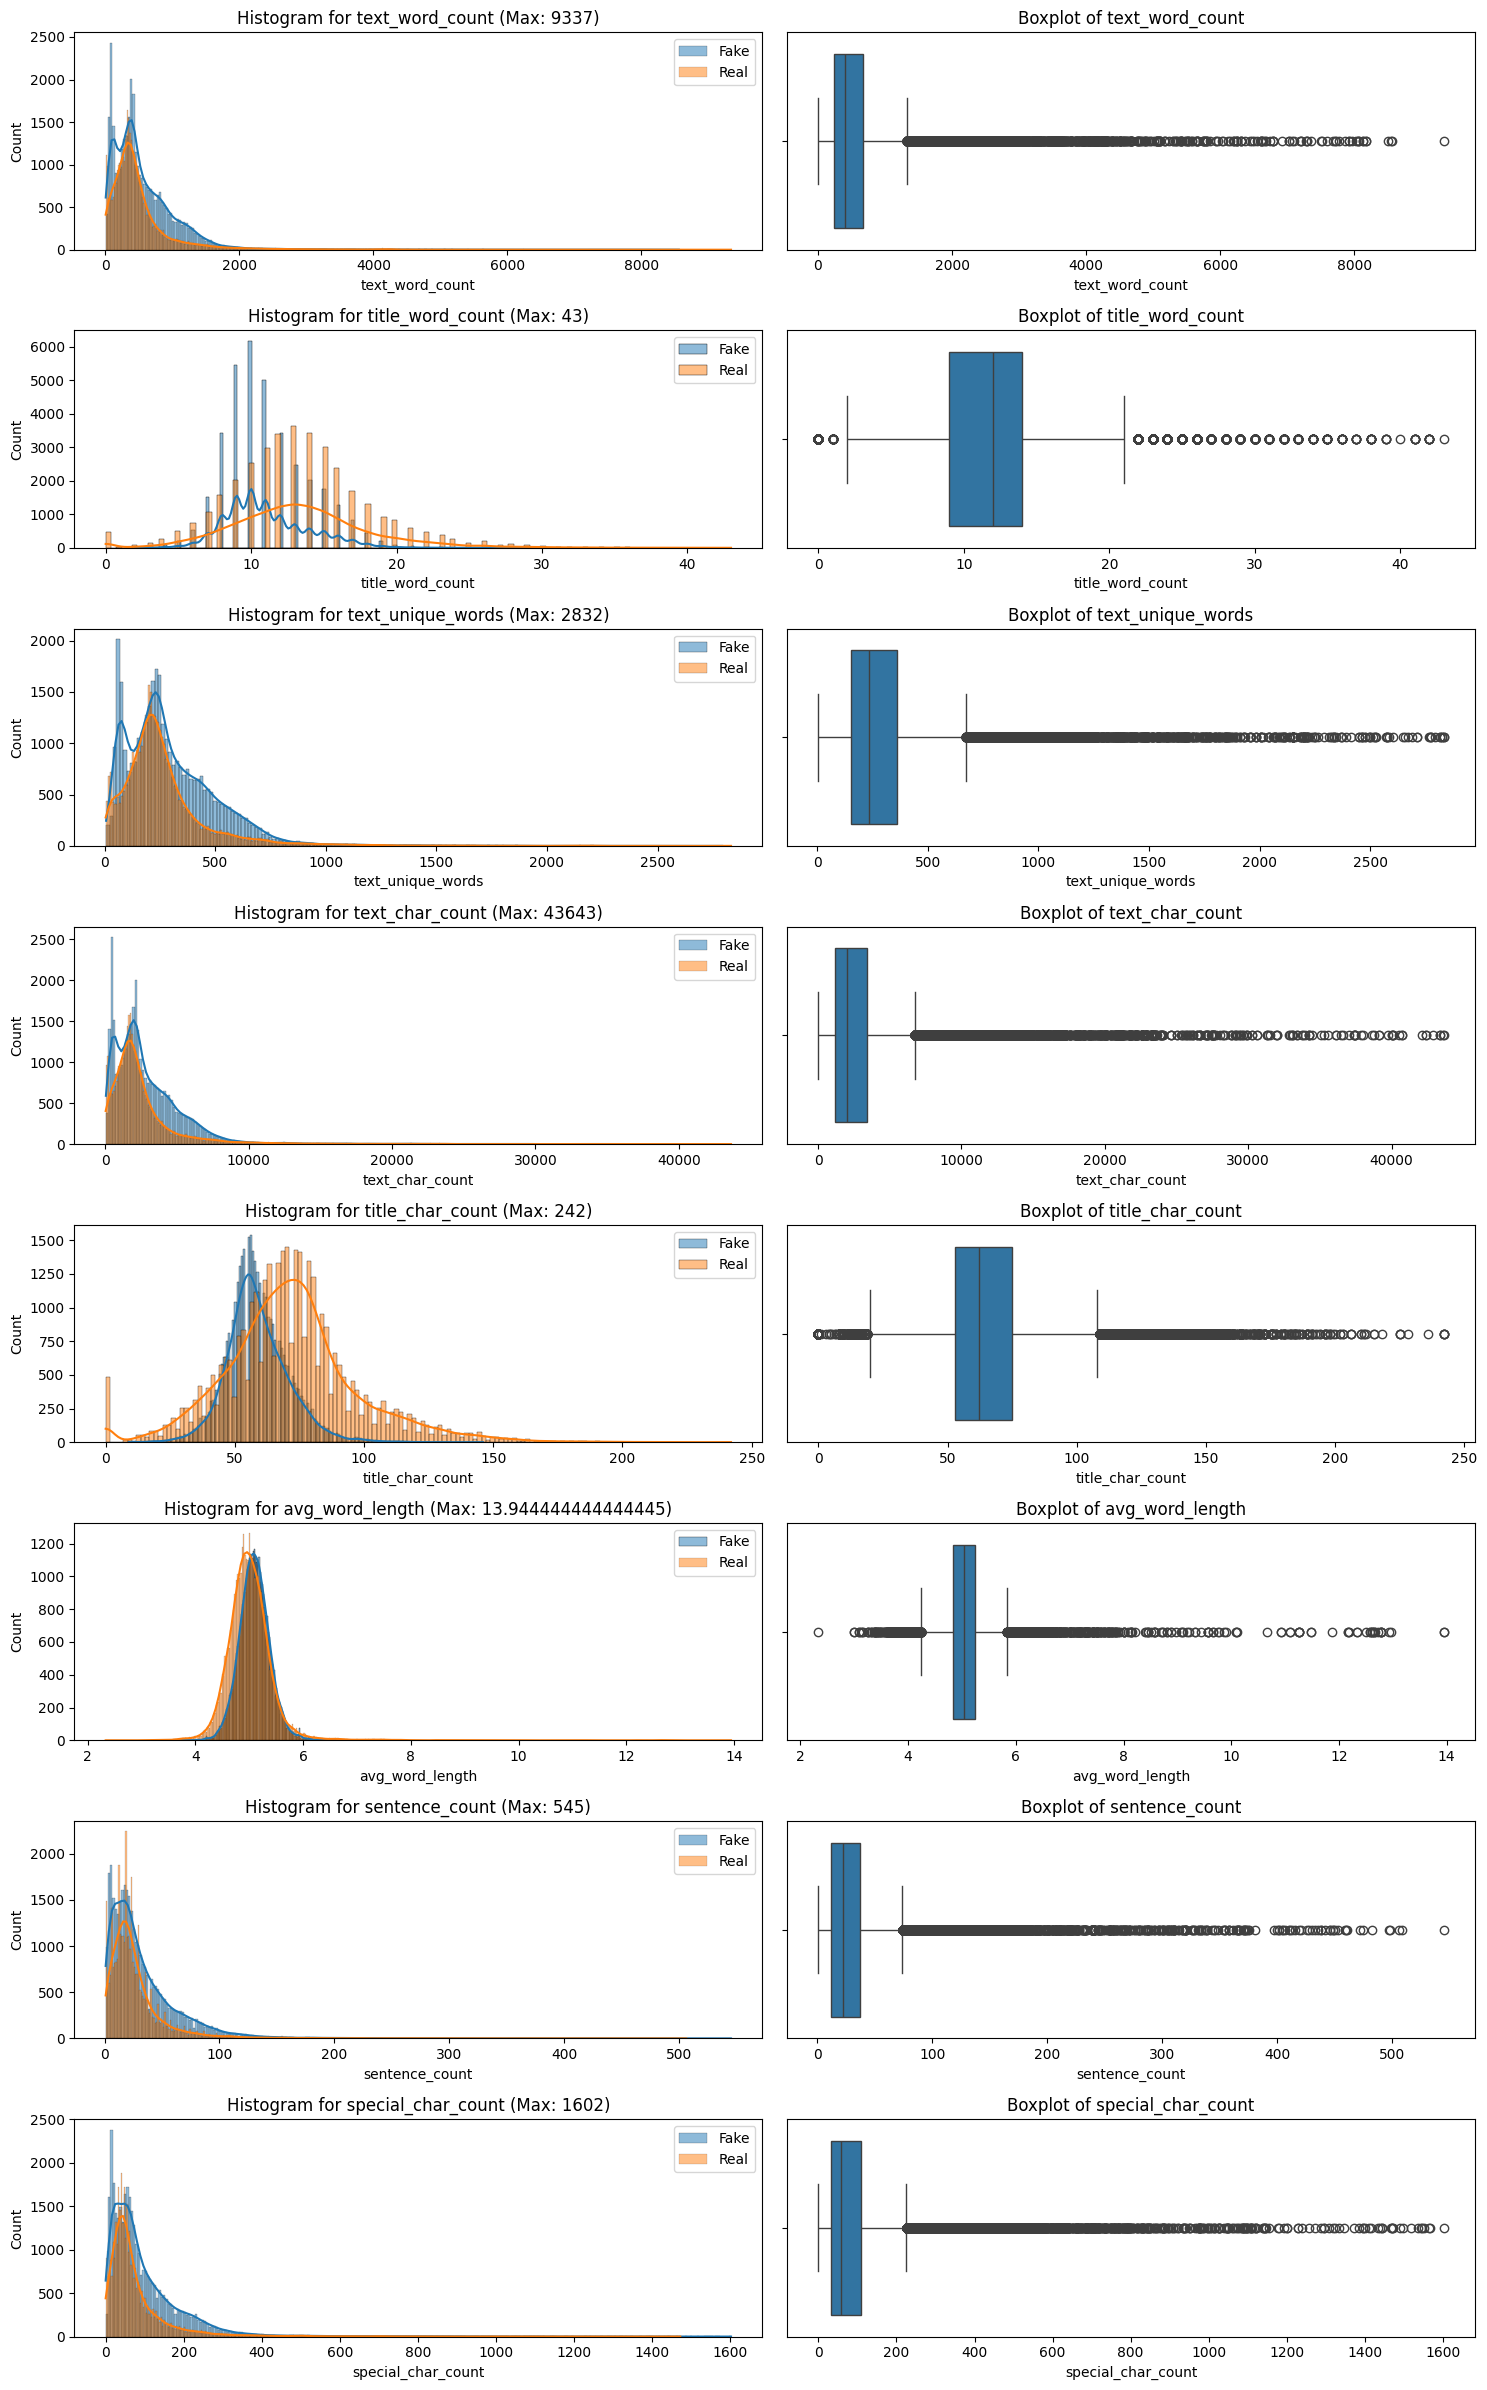

In [65]:
plot_histograms_and_boxplots(df_rm, num_cols)

In [70]:
pd.crosstab(index=df_rm.label, columns='Proportion', normalize=True)

col_0,Protprtion
label,
0,0.503812
1,0.496188


# Check distribution of the target

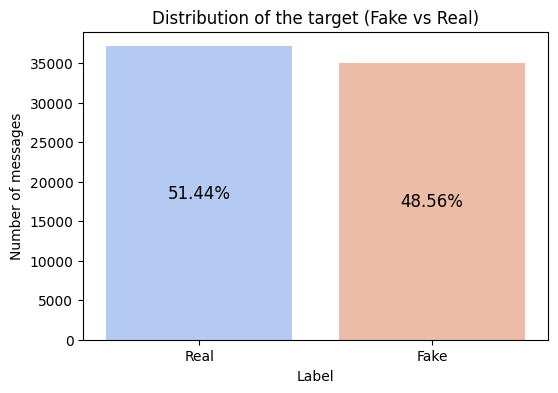

In [56]:
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='label', data=df, palette='coolwarm')
plt.title('Distribution of the target (Fake vs Real)')
ax.set_xticklabels(['Real', 'Fake'])
plt.xlabel('Label')
plt.ylabel('Number of messages')

total = len(df)
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.2f}%'
    # percentage = f'{df.label.mean() * 100:.2f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() / 2
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=12)
    
plt.show()

In [15]:
df.sort_values(by='text', ascending= False).head(50)[['title', 'text', 'label']]

,title,text,label
11165,🚨Bill Clinton and Hillary Lolita Express Pedop...,🚨Bill Clinton and Hillary Lolita Express Pedop...,0
31816,,🙂,0
40405,俄罗斯总统观注,安理会28日会议2016年十月\n俄罗斯总统观注 伏尔泰网 | 纽约（美国） | 2016年...,0
59448,Press Secretary Affirms that Trump Believes Li...,■ White House press secretary Sean Spicer stoo...,1
61773,Trump National Security Adviser Called Russian...,■ The national security adviser appointed by ...,1
31998,Taxpayers Will Defend Trump in Suit Charging C...,■ The federal taxpayer will be defending Presi...,1
69156,White House Says Bathrobe Anecdote Is All Wet ...,"■ The White House press secretary, Sean Spicer...",1
19929,Senate Judiciary Committee Approves Gorsuch in...,"■ The Senate Judiciary Committee, in a vo...",1
9177,N.F.L.: Here’s What We Learned in Week 1 - The...,■ The Oakland Raiders defense may need some ti...,1
67956,Democrats and Feds in Dispute on Trump’s D.C. ...,■ The General Services Administration disputed...,1


In [ ]:
text = ' '.join(title for title in df['text'])

# all_text = ' '.join(df['text'].dropna())
# wordcloud = WordCloud(stopwords=stop_words, background_color='white', max_words=100).generate(all_text)

wordcloud = WordCloud(
    stopwords=stopWords,
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis', 
    max_words=100
).generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Keine Achsen anzeigen
plt.show()

In [ ]:
text = ' '.join(title for title in df['title_text'])

# Erstellen der Wordcloud
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis', 
    max_words=100
).generate(text)

# Plotten der Wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Keine Achsen anzeigen
plt.show()

In [37]:
fake_news = df[df['label'] == 1]
real_news = df[df['label'] == 0]
fake_texts = ' '.join(text for text in fake_news['title_text'])
real_texts = ' '.join(text for text in real_news['title_text'])

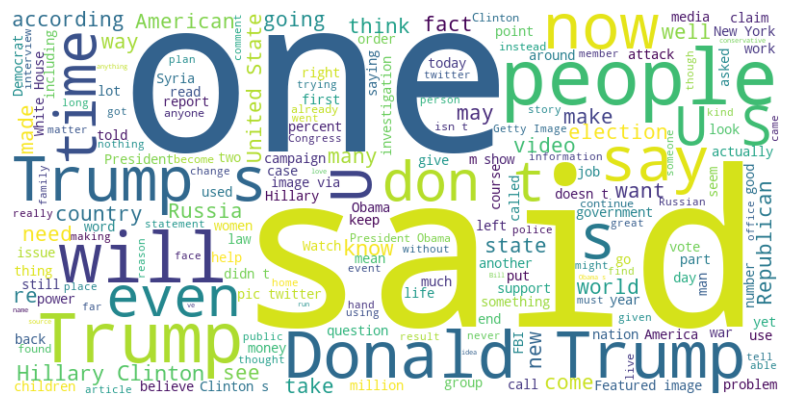

In [38]:
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis', 
    max_words=200
).generate(fake_texts)

# Plotten der Wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Keine Achsen anzeigen
plt.show()

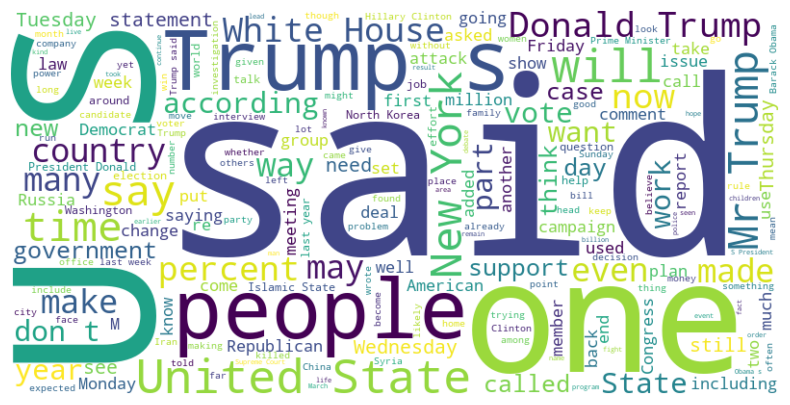

In [39]:
wordcloud = WordCloud(
    width=800, 
    height=400, 
    background_color='white', 
    colormap='viridis', 
    max_words=200
).generate(real_texts)

# Plotten der Wordcloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Keine Achsen anzeigen
plt.show()

In [ ]:
# 3.3 Most common words without stopwords

def get_most_common_words(texts, n=20):
    words = ' '.join(texts).split()
    filtered_words = [word.lower() for word in words if word.lower() not in stopWords and word.isalpha()]
    most_common = Counter(filtered_words).most_common(n)
    return pd.DataFrame(most_common, columns=['Word', 'Frequency'])

most_common_words = get_most_common_words(df['text'].dropna(), n=20)
print("\nMost common words (without stopwords):")
print(most_common_words)

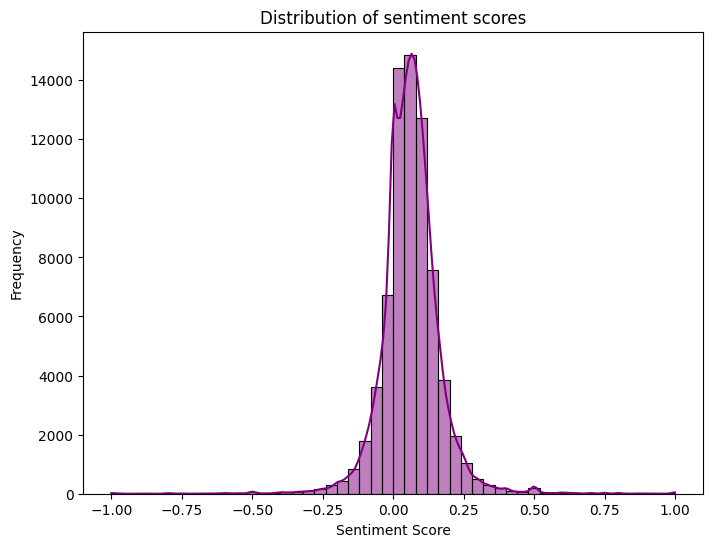

In [8]:
# 4. Sentiment Analysis

def get_sentiment(text):
    analysis = TextBlob(str(text))
    return analysis.sentiment.polarity

df['sentiment'] = df['text'].apply(get_sentiment)

plt.figure(figsize=(8, 6))
sns.histplot(df['sentiment'], bins=50, kde=True, color='purple')
plt.title('Distribution of sentiment scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

## EDA Completed – Key Findings:
The exploratory data analysis (EDA) has been completed, revealing several important insights:

* The target variable is **evenly distributed**. However, since the dataset has been compiled from various sources, it appears to have already undergone **resampling**.
* A total of **10,740 rows contain duplicates** in either the **text** or **title** columns, affecting **15% of the dataset**. Notably, only **1% of these duplicates belong to the "Fake News" category**, meaning their removal would significantly impact the target variable's distribution.

## Feature Engineering:
New features were generated during the EDA and can also be utilized for modeling:

* **title_text**: Concatenation of the title and text columns.
* **text_word_count**: Number of words in the text column.
* **title_word_count**: Number of words in the title column.
* **text_unique_words**: Number of unique words in the text column.
* **text_char_count**: Number of characters in the text column.
* **title_char_count**: Number of characters in the title column.
* **avg_word_length**: Average word length in the text column.
* **sentence_count**: Number of sentences in the text column.
* **special_char_count**: Number of special characters in the text column.
* **language**: Estimated language of the text column.

## Handling Missing Values:
The dataset contains missing values, which are replaced with **empty strings**. This ensures that concatenating the title and text columns does not result in NaN values.

## Outliers & Distribution Analysis:
* The **difference between the mean and median** across all numerical features, along with **strong right-skewed distributions**, indicates **potential outliers** in the dataset. These could significantly impact model performance.
* Outliers were **manually identified** and primarily consist of:
    - **Empty entries**.
    - **Entries with text_word_count > 0 & < 6**, which cannot be considered meaningful messages. Most single-word entries consist solely of a URL.
    - **text_word_count > 10,000**: While these entries are very long, they exhibit no other abnormalities.
    - **title_word_count > 45**: Similar to text_word_count, these are very long but otherwise unremarkable.
    - **text_unique_words > 3,000**: Contain an unusually high number of unique words but show no other anomalies.
    - **text_char_count > 50,000**: Extremely long texts with no other abnormalities.
    - **title_char_count > 300**: Very long titles, but otherwise normal.
    - **avg_word_length > 15**: Almost exclusively consists of entries that primarily contain URLs.
    - **sentence_count > 550**: Contain an abnormally high number of sentences but no other abnormalities.
    - **special_char_count > 2,000**: Consist almost entirely of non-English messages. Many also contain non-English characters, leading to a high frequency of special characters.
* Since **non-English entries are rare and sparsely represented** in the dataset, they are classified as **potential outliers**. Additionally, many of these entries are **empty or meaningless**.

# Impact on Modeling:
To assess the effect of outliers on model performance, two datasets will be tested:

1. **Dataset excluding outliers**
2. **Dataset including outliers**

The evaluation process will follow these steps:

1. **Step 1**: Ignore outliers and develop the model without them.
2. **Step 2**: Check the model’s performance on the outliers.
3. **Step 3**: If outliers are absolutely necessary, re-train the model with them.

## Feature Selection & Multicollinearity:
Some of the newly created features show **strong intercorrelation**. Therefore, a **dedicated feature selection process** will be required, which will be performed during the modeling phase.

# Prepare dataset for modeling

In [8]:
df = pd.read_csv('./data/WELFake_Dataset.csv')

data cleaning

In [9]:
df = clean_data(df)

Prepare features

In [10]:
df = prepare_features(df)

In [11]:
from spacy.lang.en.examples import sentences
nlp = spacy.load('en_core_web_sm')
type(nlp)

spacy.lang.en.English

In [12]:
# save punctuations and print them
punctuations = string.punctuation
print(punctuations)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


To use the title and text columns for modeling, they were combined into a new feature called title_text within the prepare_features function. The text_cleaner function is then applied to this new column and creates a new feature called title_text_cleaned.

In [ ]:
# Apply text_cleaner
from tqdm import tqdm

# Progress bar
results = []
for _, row in tqdm(df.iterrows(), total=len(df), desc="Progress"):
    results.append(text_cleaner(row['title_text']))

df['title_text_clean'] = results

Progress:   1%|▏                                     | 439/72134 [00:43<3:18:17,  6.03it/s]

In [ ]:
df.head()

In [3]:
path = './data/Dataset_cleaned.csv'

In [14]:
with open(path, 'w', encoding='utf-8', newline='') as file:
    df.to_csv(file, index=False)

print(f"CSV file was successfully saved under: {path}")

CSV file was successfully saved under: ./data/Dataset_cleaned.csv


In [4]:
with open(path, 'r', encoding='utf-8') as file:
    df_cleaned = pd.read_csv(file)

df_cleaned.head()

,title,text,label,title_text,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count,sentiment,title_text_clean
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,871,18,405,4109,113,4.717566,59,182,0.033103,law enforcement high alert follow threats cops...
1,,Did they post their votes for Hillary already?,0,Did they post their votes for Hillary already?,8,0,8,39,0,4.875000,1,1,0.000000,post vote hillary already
2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",0,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,34,18,31,179,120,5.264706,2,2,0.258929,unbelievable obama ’s attorney general say mos...
3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,1,"Bobby Jindal, raised Hindu, uses story of Chri...",1321,16,676,6721,90,5.041635,62,209,0.113865,bobby jindal raise hindu use story christian c...
4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",0,SATAN 2: Russia unvelis an image of its terrif...,329,16,186,1588,80,4.823708,12,50,0.056373,satan 2 russia unveli image terrifying new sup...


In [5]:
from sklearn.model_selection import train_test_split

X = df_cleaned.drop(columns=['title', 'text', 'label', 'title_text'])
y = df_cleaned.loc[:, 'label']

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [8]:
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.pipeline import Pipeline

# num_cols = df_cleaned.select_dtypes(include=['number']).columns.drop('label')
# text_col = 'title_text_clean'

# reprocessor = ColumnTransformer([
#     ('num', StandardScaler(), num_cols),
#     ('text', CountVectorizer(), text_col)
# ])

# X_train = preprocessor.fit_transform(X_train)
# X_test = preprocessor.transform(X_test)

# print(X_train.toarray())

In [6]:
X_train.head()

,text_word_count,title_word_count,text_unique_words,text_char_count,title_char_count,avg_word_length,sentence_count,special_char_count,sentiment,title_text_clean
60480,637,12,375,3295,69,5.172684,39,100,0.047439,media go nuts trump tweets hilarious video sho...
61738,461,10,268,2399,49,5.203905,26,63,-0.055842,poll find white republicans angry nearly time...
30459,118,6,88,599,44,5.076271,5,11,0.020536,germany call may 's brexit speech disappointin...
55435,147,11,116,771,50,5.231293,16,65,0.110204,factbox trump twitter oct 20 tax cut united ki...
14350,420,16,245,2148,84,5.083333,29,95,-0.126901,trump campaign say hillary supporter try assas...


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
X_train_bow = count_vectorizer.fit_transform(X_train['title_text_clean'])
X_test_bow = count_vectorizer.transform(X_test['title_text_clean'])

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train['title_text_clean'])
X_test_tfidf = tfidf_vectorizer.transform(X_test['title_text_clean'])

In [8]:
print(f"X_train_bow Shape: {X_train_bow.shape}")  
print(f"y_train Shape: {y_train.shape}")

X_train_bow Shape: (50493, 193752)
y_train Shape: (50493,)


In [9]:
from sklearn.ensemble import RandomForestClassifier

rf_classifier_bow = RandomForestClassifier(n_estimators=100, max_depth=12, class_weight='balanced', random_state=0)

rf_classifier_bow.fit(X_train_bow, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12, random_state=0)

              precision    recall  f1-score   support

        Real       0.86      0.92      0.89     11028
        Fake       0.91      0.85      0.88     10613

    accuracy                           0.88     21641
   macro avg       0.88      0.88      0.88     21641
weighted avg       0.88      0.88      0.88     21641



<Axes: >

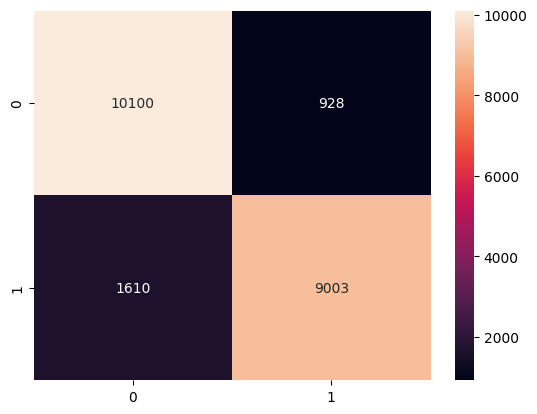

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_test_pred_rf = rf_classifier_bow.predict(X_test_bow)
print(classification_report(y_test, y_test_pred_rf, target_names=["Real", "Fake"]))
cm = confusion_matrix(y_test, y_test_pred_rf)

sns.heatmap(cm, annot=True, fmt='d')

In [13]:
rf_classifier_tfidf = RandomForestClassifier(n_estimators=300, max_depth=12, class_weight='balanced', random_state=0)

rf_classifier_tfidf.fit(X_train_tfidf, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=12, n_estimators=300,
                       random_state=0)

              precision    recall  f1-score   support

        Real       0.88      0.91      0.90     11028
        Fake       0.91      0.87      0.89     10613

    accuracy                           0.89     21641
   macro avg       0.90      0.89      0.89     21641
weighted avg       0.89      0.89      0.89     21641



<Axes: >

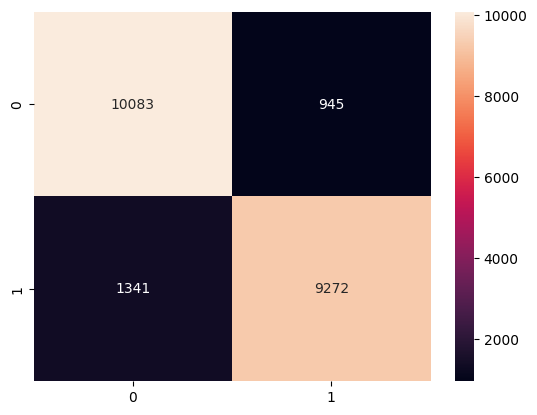

In [14]:
y_test_pred_rf_tfidf = rf_classifier_tfidf.predict(X_test_tfidf)
print(classification_report(y_test, y_test_pred_rf_tfidf, target_names=["Real", "Fake"]))

cm = confusion_matrix(y_test, y_test_pred_rf_tfidf)

sns.heatmap(cm, annot=True, fmt='d')

In [18]:
print(df_cleaned.shape)
df_no_duplicates = df_cleaned.drop_duplicates(subset=['title', 'text'])
df_no_duplicates.shape

(72134, 14)


(63678, 14)

In [21]:
X_no_dupl = df_no_duplicates.drop(columns=['title', 'text', 'label', 'title_text'])
y_no_dupl = df_no_duplicates.loc[:, 'label']

X_train_no_dupl, X_test_no_dupl, y_train_no_dupl, y_test_no_dupl = train_test_split(X_no_dupl, 
                                                    y_no_dupl, 
                                                    test_size=0.3, 
                                                    random_state=42)

count_vectorizer = CountVectorizer()
X_train_bow_np = count_vectorizer.fit_transform(X_train_no_dupl['title_text_clean'])
X_test_bow_np = count_vectorizer.transform(X_test_no_dupl['title_text_clean'])

              precision    recall  f1-score   support

        Real       0.85      0.89      0.87      8588
        Fake       0.91      0.87      0.89     10516

    accuracy                           0.88     19104
   macro avg       0.88      0.88      0.88     19104
weighted avg       0.88      0.88      0.88     19104



<Axes: >

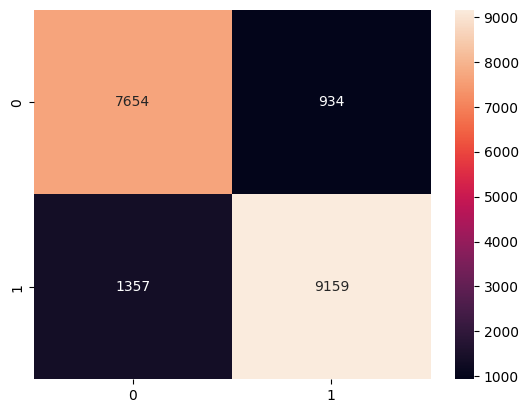

In [25]:
rf_classifier_bow_np = RandomForestClassifier(n_estimators=100, max_depth=12, class_weight='balanced', random_state=0)
rf_classifier_bow_np.fit(X_train_bow_np, y_train_no_dupl)

y_test_pred_rf_np = rf_classifier_bow_np.predict(X_test_bow_np)
print(classification_report(y_test_no_dupl, y_test_pred_rf_np, target_names=["Real", "Fake"]))
cm = confusion_matrix(y_test_no_dupl, y_test_pred_rf_np)

sns.heatmap(cm, annot=True, fmt='d')